In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import FileLink, FileLinks
import multiprocessing, logging
mpl = multiprocessing.log_to_stderr()
mpl.setLevel(logging.INFO)

import os
import sys
import glob as gb
import re
from datetime import datetime as dtime
from pathlib import Path
from itertools import repeat
import pickle
from concurrent.futures import ThreadPoolExecutor

import random

import numpy as np
import pandas as pd

from PIL import Image
import imageio

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

from mlxtend.preprocessing import minmax_scaling

from numba import jit


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.pyplot import savefig
import matplotlib.animation as animation
mpl.style.use('classic')

import pydicom as dcm
import pylab

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# from fastai.conv_learner import *
# from fastai.dataset import *
# from fastai.models.resnet import vgg_resnet50

from pathlib import Path
import json
# torch.cuda.set_device(0)
# torch.backends.cudnn.benchmark=True

from numba import cuda

import getpass
import os

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(True)

import keras
from keras.utils.data_utils import Sequence
from keras.callbacks import TensorBoard
from keras.models import load_model

import tensorflow as tf


from sklearn import preprocessing
import matplotlib.animation as animation

# See https://stackoverflow.com/questions/14722540/smoothing-between-pixels-of-imagesc-imshow-in-matlab-like-the-matplotlib-imshow
mpl.rcParams['image.interpolation'] = 'none' # default 'bilinear'

layout=Layout(width='90%') # For ipywidgets

plt.rcParams['figure.figsize']= [7.0, 7.0]

#import ipdb; ipdb.set_trace()

/home/amer/anaconda3/envs/fast/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Using TensorFlow backend.


In [2]:
from unet3d import *
from unet3d.utils.patches import *
from unet3d.metrics import *
from unet3d.model import *
from unet3d.generator import *
from unet3d.training import *
from unet3d.augment import *
from brats.preprocess import *

In [156]:
# Pathes
HOME = Path.home()

DATA = HOME / 'data/aneurysm'
PATH = DATA

#BIGDISK = DATA / 'bigdisk'
BIGDISK = Path('/media/amer/BigDisk/')
BIGDISK.mkdir(exist_ok=True)

TEST_DCM = BIGDISK / 'some_fixed_files/256Test/'
TEST_DCM_MASK = BIGDISK / 'some_fixed_files/256Test.mask/'

TEST_PRO = BIGDISK / 'some_fixed_files/256Test.processed/'
TEST_PRO.mkdir(exist_ok=True)

TESTDATA_PREDICTIONS = BIGDISK / 'testdata_predictions'
TESTDATA_PREDICTIONS.mkdir(exist_ok=True)

CT_DCM = DATA / 'ct-512'
MASK_DCM = DATA / 'mask-512'

PATCHES = BIGDISK/'Processed_data'
PATCHES.mkdir(exist_ok=True)

GRAPHS = DATA/'Graphs'
GRAPHS.mkdir(exist_ok=True)

MODELS = PATH/'models'
MODELS.mkdir(exist_ok=True)

TMP = DATA / 'tmp'

In [4]:
ct_dcms = np.array(sorted(list(CT_DCM.iterdir())))
mask_dcms = np.array(sorted(list(MASK_DCM.iterdir())))

In [5]:
def dicom_shape(path):
    name = path.stem
    pixel_array = dcm.read_file(str(path)).pixel_array
    return name,np.shape(pixel_array),pixel_array

def first_nonempty_slice_index(tensor):
    last = np.shape(tensor)[0]
    for i in range(0,last):
        max_val = np.max(tensor[i])
        if max_val > 0:
            return i
        
def last_nonempty_slice_index(tensor):
    last = np.shape(tensor)[0]
    for i in range(0,last)[::-1]:
        max_val = np.max(tensor[i])
        if max_val > 0:
            return i

def imshow(pixel_array):
    pixel_array[pixel_array > 0] = 255
    pixel_array = pixel_array.astype(np.uint8)
    return Image.fromarray(pixel_array)

def mask_dcm_to_png(path,target_dir,size=False):
    name = path.stem
    pixel_array = dcm.read_file(str(path)).pixel_array[:-2] # remove the last to layers
    layers = np.shape(pixel_array)[0]
    if size:
        for i in range(layers):
            clean_mask(pixel_array[i]).resize(size).save(str(target_dir/f"{name}_{i}.png"))
    else:
        for i in range(layers):
            clean_mask(pixel_array[i]).save(str(target_dir/f"{name}_{i}.png"))
    print(f"{name}",end=", ")
    
def ct_dcm_to_png(path,target_dir,size=False):
    name = path.stem
    pixel_array = dcm.read_file(str(path)).pixel_array[:-2] # remove the last to layers
    layers = np.shape(pixel_array)[0]
    if size:
        for i in range(layers):
            Image.fromarray(pixel_array[i]).resize(size).save(str(target_dir/f"{name}_{i}.png"))
    else:
        for i in range(layers):
            Image.fromarray(pixel_array[i]).save(str(target_dir/f"{name}_{i}.png"))
    print(f"{name}",end=", ")
    
def get_ct_by_index(index):
    return dcm.read_file(str(ct_dcms[index])).pixel_array

def get_mask_by_index(index):
    pa = dcm.read_file(str(mask_dcms[index])).pixel_array.copy()
    pa[pa > 0] = 1
    return pa

def chance(probability):
    return random.random() < probability

In [6]:
@jit
def get_patch_from_3d_data(data, patch_shape, patch_index):
    """
    Returns a patch from a numpy array.
    :param data: numpy array from which to get the patch.
    :param patch_shape: shape/size of the patch.
    :param patch_index: corner index of the patch.
    :return: numpy array take from the data with the patch shape specified.
    """
    patch_index = np.asarray(patch_index, dtype=np.int16)
    patch_shape = np.asarray(patch_shape)
    image_shape = data.shape[-3:]
    if np.any(patch_index < 0) or np.any((patch_index + patch_shape) > image_shape):
        data, patch_index = fix_out_of_bound_patch_attempt(data, patch_shape, patch_index)
    return data[..., patch_index[0]:patch_index[0]+patch_shape[0], patch_index[1]:patch_index[1]+patch_shape[1],
                patch_index[2]:patch_index[2]+patch_shape[2]]
@jit
def fix_data_shape(data, patch_shape, patch_index):
    if np.any(patch_index < 0) or np.any((patch_index + patch_shape) > image_shape):
        data, patch_index = fix_out_of_bound_patch_attempt(data, patch_shape, patch_index)
        return data

@jit
def fix_out_of_bound_patch_attempt(data, patch_shape, patch_index, ndim=3):
    """
    Pads the data and alters the patch index so that a patch will be correct.
    :param data:
    :param patch_shape:
    :param patch_index:
    :return: padded data, fixed patch index
    """
    image_shape = data.shape[-ndim:]
    pad_before = np.abs((patch_index < 0) * patch_index)
    pad_after = np.abs(((patch_index + patch_shape) > image_shape) * ((patch_index + patch_shape) - image_shape))
    pad_args = np.stack([pad_before, pad_after], axis=1)
    if pad_args.shape[0] < len(data.shape):
        pad_args = [[0, 0]] * (len(data.shape) - pad_args.shape[0]) + pad_args.tolist()
    data = np.pad(data, pad_args, mode="edge")
    patch_index += pad_before
    return data, patch_index

In [7]:
# a = np.ones((512, 512, 512))

# def pad_data(data):
#     d = data.shape[0]
#     m = (d%64)
#     print(m)
#     return np.pad(a, pad_width=((0, m),(0,0),(0,0)), mode='edge')

# print(pad_data(a).shape)

In [8]:
patient = 1 # 1

ct = get_ct_by_index(patient)
mask = get_mask_by_index(patient)

image_shape = np.shape(ct)
patch_shape = (64,64,64)

overlap = 8

patch_indices = compute_patch_indices(image_shape, patch_shape, overlap, start=None)

print(len(patch_indices))

def dshow():
    ct_patch = get_patch_from_3d_data(ct, patch_shape, patch_indices[0])
    mask_patch = get_patch_from_3d_data(mask, patch_shape, patch_indices[0])
    def show_layer(layer_num,patch_num):
        ct_patch = get_patch_from_3d_data(ct, patch_shape, patch_indices[patch_num])
        c = ct_patch
        mask_patch = get_patch_from_3d_data(mask, patch_shape, patch_indices[patch_num])
        ct_patch = np.array(ct_patch,dtype=np.float32)
        output_image = sitk.GetImageFromArray(ct_patch,)
        output_image = sitk.N4BiasFieldCorrection(output_image, output_image > 0)
        ct_patch = sitk.GetArrayFromImage(output_image)
        
        f = plt.figure(figsize=(20,10))
        f.add_subplot(1,2, 1)
        pylab.imshow(ct_patch[layer_num])
        #print(np.unique(ct_patch[layer_num]))
        f.add_subplot(1,2, 2)
        pylab.imshow(c[layer_num])
        #print(np.unique(c[layer_num]))
        plt.show(block=True)
    
    interact(show_layer,
             patch_num=widgets.IntSlider(min=0,max=len(patch_indices)-1,step=1,layout=layout,value=150),
             layer_num=widgets.IntSlider(min=0,max=len(ct_patch)-1,step=1,layout=layout,value=63)
            )

dshow()

800


interactive(children=(IntSlider(value=63, description='layer_num', layout=Layout(width='90%'), max=63), IntSli…

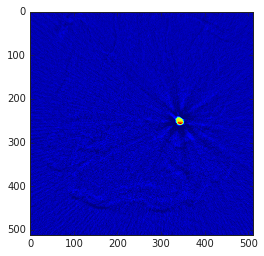

In [9]:
#plt.imshow(get_mask_by_index(1)[19])
plt.imshow(get_ct_by_index(1)[19])

In [10]:
patient = 1 # 1

ct = get_ct_by_index(patient)
mask = get_mask_by_index(patient)

image_shape = np.shape(ct)
patch_shape = (64,64,64)

overlap = 0

patch_indices = compute_patch_indices(image_shape, patch_shape, overlap, start=None)

def dshow():
    ct_patch = get_patch_from_3d_data(ct, patch_shape, patch_indices[0])
    mask_patch = get_patch_from_3d_data(mask, patch_shape, patch_indices[0])
    @jit
    def show_layer(layer_num,patch_num):
        ct_patch = get_patch_from_3d_data(ct, patch_shape, patch_indices[patch_num])
        mask_patch = get_patch_from_3d_data(mask, patch_shape, patch_indices[patch_num])
        
        f = plt.figure(figsize=(20,10))
        f.add_subplot(1,2, 1)
        pylab.imshow(ct_patch[layer_num])
        #print(np.unique(ct_patch[layer_num]))
        f.add_subplot(1,2, 2)
        pylab.imshow(mask_patch[layer_num])
        #print(np.unique(mask_patch[layer_num]))
        plt.show(block=True)
    
    interact(show_layer,
             patch_num=widgets.IntSlider(min=0,max=len(patch_indices)-1,step=1,layout=layout,value=150),
             layer_num=widgets.IntSlider(min=0,max=len(ct_patch)-1,step=1,layout=layout,value=63)
            )

dshow()

interactive(children=(IntSlider(value=63, description='layer_num', layout=Layout(width='90%'), max=63), IntSli…

In [11]:
patient = 1 # 1

ct = get_ct_by_index(patient)
mask = get_mask_by_index(patient)

image_shape = np.shape(ct)
patch_shape = (64,64,64)

overlap = 0

patch_indices = compute_patch_indices(image_shape, patch_shape, overlap, start=None)

def dshow():
    ct_patch = get_patch_from_3d_data(ct, patch_shape, patch_indices[0])
    mask_patch = get_patch_from_3d_data(mask, patch_shape, patch_indices[0])
    def show_layer(layer_num,patch_num):
        ct_patch = get_patch_from_3d_data(ct, patch_shape, patch_indices[patch_num])
        mask_patch = get_patch_from_3d_data(mask, patch_shape, patch_indices[patch_num])
        
        ct_patch = ct_patch/np.linalg.norm(ct_patch, ord=2,axis=-1,keepdims=1)
        
        f = plt.figure(figsize=(20,10))
        f.add_subplot(1,2, 1)
        normalized_X = preprocessing.normalize(get_patch_from_3d_data(ct, patch_shape, patch_indices[patch_num])[layer_num])
        pylab.imshow(normalized_X)
        print(normalized_X.dtype)
        print(np.unique(normalized_X))
        f.add_subplot(1,2, 2)
        X = ct_patch[layer_num]
        pylab.imshow(X)
        print(X.dtype)
        print(np.unique(X))
        plt.show(block=True)
    
    interact(show_layer,
             patch_num=widgets.IntSlider(min=0,max=len(patch_indices)-1,step=1,layout=layout,value=150),
             layer_num=widgets.IntSlider(min=0,max=len(ct_patch)-1,step=1,layout=layout,value=63)
            )

dshow()

interactive(children=(IntSlider(value=63, description='layer_num', layout=Layout(width='90%'), max=63), IntSli…

In [12]:
patient = 1 # 1

ct = get_ct_by_index(patient)
mask = get_mask_by_index(patient)

image_shape = np.shape(ct)
patch_shape = (64,64,64)

overlap = 0

patch_indices = compute_patch_indices(image_shape, patch_shape, overlap, start=None)

def dshow():
    ct_patch = get_patch_from_3d_data(ct, patch_shape, patch_indices[0])
    mask_patch = get_patch_from_3d_data(mask, patch_shape, patch_indices[0])
    @jit
    def show_layer(layer_num,patch_num):
        ct_patch = get_patch_from_3d_data(ct, patch_shape, patch_indices[patch_num])
        c = ct_patch
        mask_patch = get_patch_from_3d_data(mask, patch_shape, patch_indices[patch_num])
        ct_patch = np.array(ct_patch,dtype=np.float32)
        output_image = sitk.GetImageFromArray(ct_patch,)
        output_image = sitk.N4BiasFieldCorrection(output_image, output_image > 0)
        ct_patch = sitk.GetArrayFromImage(output_image)
        
        f = plt.figure(figsize=(20,10))
        f.add_subplot(1,2, 1)
        pylab.imshow(ct_patch[layer_num])
        print(np.unique(ct_patch[layer_num]))
        f.add_subplot(1,2, 2)
        pylab.imshow(c[layer_num])
        print(np.unique(c[layer_num]))
        plt.show(block=True)
    
    interact(show_layer,
             patch_num=widgets.IntSlider(min=0,max=len(patch_indices)-1,step=1,layout=layout,value=150),
             layer_num=widgets.IntSlider(min=0,max=len(ct_patch)-1,step=1,layout=layout,value=63)
            )

dshow()

interactive(children=(IntSlider(value=63, description='layer_num', layout=Layout(width='90%'), max=63), IntSli…

In [14]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs',
                                         histogram_freq=0,
                                         write_graph=True,
                                         write_images=True)

In [15]:
def train_model(model, model_file, training_generator, validation_generator, steps_per_epoch, validation_steps,
                initial_learning_rate=0.001, learning_rate_drop=0.5, learning_rate_epochs=None, n_epochs=100,
                learning_rate_patience=20, early_stopping_patience=None):
    """
    Train a Keras model.
    :param early_stopping_patience: If set, training will end early if the validation loss does not improve after the
    specified number of epochs.
    :param learning_rate_patience: If learning_rate_epochs is not set, the learning rate will decrease if the validation
    loss does not improve after the specified number of epochs. (default is 20)
    :param model: Keras model that will be trained.
    :param model_file: Where to save the Keras model.
    :param training_generator: Generator that iterates through the training data.
    :param validation_generator: Generator that iterates through the validation data.
    :param steps_per_epoch: Number of batches that the training generator will provide during a given epoch.
    :param validation_steps: Number of batches that the validation generator will provide during a given epoch.
    :param initial_learning_rate: Learning rate at the beginning of training.
    :param learning_rate_drop: How much at which to the learning rate will decay.
    :param learning_rate_epochs: Number of epochs after which the learning rate will drop.
    :param n_epochs: Total number of epochs to train the model.
    :return: 
    """
    
    this_callbacks = get_callbacks(model_file,
                  initial_learning_rate=initial_learning_rate,
                  learning_rate_drop=learning_rate_drop,
                  learning_rate_epochs=learning_rate_epochs,
                  learning_rate_patience=learning_rate_patience,
                  early_stopping_patience=early_stopping_patience)
    
    this_callbacks.append(tbCallBack)

    model.fit_generator(generator=training_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=n_epochs,
                        validation_data=validation_generator,
                        validation_steps=validation_steps,
                        callbacks=this_callbacks)
    return model

In [16]:
class DicomAccess():    
    @classmethod
    def get_ct(self,idx):
        try:
            iter(idx)
        except TypeError:
            idx = [idx]
        return np.array([dcm.read_file(str(path)).pixel_array for path in ct_dcms[idx]])

    @classmethod
    def get_mask(self,idx):
        try:
            iter(idx)
        except TypeError:
            idx = [idx]
        return np.array([dcm.read_file(str(path)).pixel_array for path in mask_dcms[idx]])

In [17]:
from functools import reduce

class DataSet():
    def __init__(self,imgs,masks):
        self.len = len(imgs)
        self.current = 0
        self.imgs = imgs
        self.masks = masks
        if not self.check_data():
            print("Something is wrong with the data.")
        else:
            print("Data seems to be fine.")

    def check_data(self):
        imgs = np.array([Path(f.stem).stem for f in self.imgs])
        masks = np.array([Path(f.stem).stem for f in self.masks])
        return (reduce(np.intersect1d, (imgs,masks)) == imgs).all()
        
    def get_ct(self,idx):
        try:
            iter(idx)
        except TypeError:
            idx = [idx]
        return np.array([dcm.read_file(str(path)).pixel_array for path in self.imgs[idx]])

    def get_mask(self,idx):
        try:
            iter(idx)
        except TypeError:
            idx = [idx]
        return np.array([dcm.read_file(str(path)).pixel_array for path in self.masks[idx]])
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        yield tuple((self.get_ct(idx),self.get_mask(idx)))
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current >= len(self):
            raise StopIteration
        else:
            self.current += 1
            return tuple((self.get_ct(self.current),self.get_mask(self.current)))


In [18]:
# shapes = [np.shape(list(dataset[x]))[3:] for x in range(10)]

In [68]:
class DataPreparator():
    def __init__(self,dataset,patch_shape,batch_size,overlap,output_dir):
        self.dataset = dataset
        self.patch_shape = patch_shape
        self.batch_size = batch_size
        self.overlap = overlap
        self.patches = []
        self.masked = []
        self.output_dir = output_dir
        self.metadata = {
            "ct_idx": [],
            "patches_shape": [],
            "masked": [],
            "pickles": [],
            "patch_indices": [],
        }
        
    def load_metadata(self,file=None):
        if not file:
            file = str(self.output_dir/'metadata.p')
        else:
            file = str(file)
        self.metadata = self.pickle_load(file)
        return self.metadata
        
    def prepare(self):
        for idx in range(len(self.dataset)):
            arr = list(self.dataset[idx])
            x,y = arr[0][0][0],arr[0][1][0]
            image_shape = np.shape(x)
            print(f"Image,Mask ({idx}): {image_shape}")
            patch_indices = compute_patch_indices(image_shape, self.patch_shape, self.overlap, start=None)
            
            with ThreadPoolExecutor(6) as e:
                e.map(
                    self.save_patches,
                    repeat(patch_indices),
                    repeat(x),
                    repeat(y),
                    range(len(patch_indices)),
                    repeat(idx),
                     )
            
            data_obj = {
                'patches': self.patches,
                'masked': self.masked,
            }
            
            fname = "data_%05d.p" % (idx)
            out_file = str(self.output_dir/fname)
            print(f"\nDumping a pickle at {out_file}... ",end='')
            print(np.shape(self.patches))
            self.pickle_dump(item=data_obj, out_file=out_file)
            print("Done.")
            self.metadata['pickles'].append(fname)
            
            self.patches = []
            self.masked = []
            
        metadate_out_file = str(self.output_dir/f"metadata.p")
        self.pickle_dump(item=self.metadata, out_file=metadate_out_file)
        print(f"Metadata has been saved in {metadate_out_file}")

    def save_patches(self,patch_indices,x,y,patch_index,ct_idx):
        y_patch = self.get_patch(y,patch_indices,patch_index)
        has_mask = self.has_mask(y_patch)
        
        take = chance(0.02)
        if has_mask:
            print('m',end='')
        elif take:
            print('t',end='') # took an empty patch by chance
        else:
            print('.',end='') # skiped an empty patch
            return
            

        x_patch = self.get_patch(x,patch_indices,patch_index)
        x_patch = self.normalize_patch(x_patch)
        y_patch = self.to_binary_mask(y_patch)
        
        xy_patch_out = tuple(np.array([[x_patch],[y_patch]]))
        has_mask = self.has_mask(y_patch)
        self.masked.append(has_mask)
        self.patches.append(xy_patch_out)
        self.metadata["patches_shape"].append(np.shape(xy_patch_out))
        self.metadata["masked"].append(has_mask)
        self.metadata["ct_idx"].append(ct_idx)
        self.metadata["patch_indices"].append(patch_index)
        #print(f"Patch ({idx}) {np.shape(patch_indices)}: {np.shape(xy_patch_out)}")
            
    def get_patch(self,data,patch_indices,idx):
        return self.reshape_array(
            get_patch_from_3d_data(data, self.patch_shape, patch_indices[idx]))
        
    @classmethod
    def pickle_dump(self,item, out_file):
        with open(str(out_file), "wb") as opened_file:
            pickle.dump(item, opened_file, protocol=pickle.HIGHEST_PROTOCOL)

    @classmethod
    def pickle_load(self,in_file):
        with open(str(in_file), "rb") as opened_file:
            return pickle.load(opened_file)

    @classmethod
    def reshape_array(self,arr):
        new_shape = tuple(np.insert(np.shape(arr),0,1))
        return np.reshape(arr,new_shape)
    
    @classmethod
    def has_mask(self,patch):            
        if np.any(patch):
            return True
        else:
            return False
            
    @classmethod       
    def normalize_patch_1(self,patch):
        return patch/np.linalg.norm(patch, ord=2,axis=-1,keepdims=1)
    
    @classmethod
    @jit
    def normalize_patch(self,x):
        return (x - x.min()) / (x.max() - x.min())
    
    @classmethod
    def to_binary_mask(self,patch):
        patch[patch > 0] = 1
        return patch

ct_dcms = np.array(sorted(list(CT_DCM.iterdir())))
mask_dcms = np.array(sorted(list(MASK_DCM.iterdir())))
        
params = {
    'patch_shape': (64,64,64),
    'batch_size': 1,
    'overlap': 8,
    'output_dir': PATCHES
}

dataset = DataSet(imgs=ct_dcms,masks=mask_dcms)
dp = DataPreparator(dataset,**params)

Data seems to be fine.


In [19]:
dp.prepare()

Image,Mask (0): (439, 512, 512)
..............t.......t...........................................................................................t............................t.............................................................................mm.........mm..........................................................t...........................m.mm......m.mm...........................t................t...........................................m.......t.m......t............t..............................t..................................................t......................t.......................................................t....................................t....t.....................................................................t...................t......................................................
Dumping a pickle at /home/group1/data/aneurysm/bigdisk/Processed_data/data_00000.p... (30, 2, 1, 1, 64, 64, 64)
Done.
Image,Mask (1): (439, 512, 512)
.................

...t........t..............................t........t..........................t................................................................................................................t.....................t........t.......mm........m...m..........................................................................m.m......m..mm.......mm......t......................................................t...............mm........m.mm......mmm.......................................t....................t...t.............m........m..............................t...........................t...........................................................................................t..................................................t...t................t...t...........t..............................
Dumping a pickle at /home/group1/data/aneurysm/bigdisk/Processed_data/data_00015.p... (42, 2, 1, 1, 64, 64, 64)
Done.
Image,Mask (16): (455, 512, 512)
..................................m..m......m.mt

Done.
Image,Mask (30): (439, 512, 512)
.......................................................................................t..........................................m.........m.mt.......mm............................t...............................................mmm.......mmm....t....m.....t.........................................................................mm..t.....m.m..................................................t...........................t.......................t..................................................................................t.....................t.......................t............................................................t..........................................t.......................t.....................................t..................................................t.......
Dumping a pickle at /home/group1/data/aneurysm/bigdisk/Processed_data/data_00030.p... (33, 2, 1, 1, 64, 64, 64)
Done.
Image,Mask (31): (439, 512, 512)
.........

............t.....................................m..m......mm.....................................................................m......mm........mmm......m.m.........................................................t...........mmm......m.mm......................................................t.............................t.mmm.......mmm...........................................t......................................t...........................t............................................................................................t...................................................t.....................................t.....................................................................................................t.........................t...............................t....................................................................................................................................................................................................t........

In [69]:
test_imgs = np.array(sorted(list(TEST_DCM.iterdir())))
test_masks = np.array(sorted(list(TEST_DCM_MASK.iterdir())))



params = {
    'patch_shape': (64,64,64),
    'batch_size': 1,
    'overlap': 8,
    'output_dir': TEST_PRO, 
}

test_dataset = DataSet(test_imgs,test_masks)
test_dp = DataPreparator(test_dataset,**params)

test_dp.prepare()

Data seems to be fine.
Image,Mask (0): (220, 256, 256)
........mm.m.m..............mm...mm.............................t...................................
Dumping a pickle at /media/amer/BigDisk/some_fixed_files/256Test.processed/data_00000.p... (9, 2, 1, 1, 64, 64, 64)
Done.
Image,Mask (1): (220, 256, 256)
...........................mm..mm..................m...m...mmt......................................
Dumping a pickle at /media/amer/BigDisk/some_fixed_files/256Test.processed/data_00001.p... (9, 2, 1, 1, 64, 64, 64)
Done.
Image,Mask (2): (220, 256, 256)
.........mm.....mm...............mm..m.m...........t...t............................................
Dumping a pickle at /media/amer/BigDisk/some_fixed_files/256Test.processed/data_00002.p... (10, 2, 1, 1, 64, 64, 64)
Done.
Image,Mask (3): (220, 256, 256)
..m.....m.......t............m.m..........t.......t..................t..............................
Dumping a pickle at /media/amer/BigDisk/some_fixed_files/256Test.processed/dat

In [20]:
# print(np.count_nonzero(dp.pickle_load(PATCHES/"metadata.p")["masked"]))

# len(dp.pickle_load(PATCHES/"metadata.p")["masked"]) - np.count_nonzero(dp.pickle_load(PATCHES/"metadata.p")["masked"])

# # masked = dp.pickle_load("/home/amer/data/aneurysm/patches/data_0.p")["masked"]

In [106]:
class DataGen(Sequence):
    def __init__(self,processed_data_dir,mode=0):
        """
        :param mode: 0 for training or 1 validation, 3 for all
        """
        self.processed_data_dir = processed_data_dir
        self.mode = mode
        self.pickles = np.array([Path(file) for file in sorted(gb.glob(str(self.processed_data_dir/'data*.p')))])
        self.metadata = dp.pickle_load(self.processed_data_dir/"metadata.p")
        self.file_list = np.array([self.pickles[idx] for idx in self.metadata["ct_idx"]])
        self.all_data = np.column_stack((self.file_list, self.metadata['patch_indices']))
        if self.mode == 3:
            self.data_set = self.all_data
            self.internal_patch_index = self.get_internal_patch_index()
        else:
            self.data_set = split_list(self.all_data, split=0.8, shuffle_list=False)[self.mode]
            self.internal_patch_index = split_list(self.get_internal_patch_index(), split=0.8, shuffle_list=False)[self.mode]
        
    def __len__(self):
        return len(self.data_set)    
    
    def __getitem__(self, idx):
        pickle_path = self.data_set[idx][0]
        x,y = self.get_pickle(pickle_path)[self.internal_patch_index[idx]]
        return x,y
    
    def get_internal_patch_index(self):        
        internal_patch_count = {}
        internal_patch_index = []
        for x in self.all_data:
            try:
                internal_patch_count[x[0]] += 1
            except KeyError as e:
                internal_patch_count[x[0]] = 0
            internal_patch_index.append(internal_patch_count[x[0]])
        return np.array(internal_patch_index)
    
    def get_pickle(self,path):
        return self.pickle_load(path)['patches']
    
    @classmethod
    def pickle_load(self,in_file):
        with open(str(in_file), "rb") as opened_file:
            return pickle.load(opened_file)

    @classmethod
    def reshape_array(self,arr):
        new_shape = tuple(np.insert(np.shape(arr),0,1))
        return np.reshape(arr,new_shape)

In [79]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()


def model_file():
    t = dtime.now().strftime('%Y-%m-%d_%H:%M:%S')
    return str(MODELS/f"UnetModel_{t}.h5")

In [80]:
import keras
from keras import backend as K

def threshold_binary_accuracy(y_true, y_pred):
    threshold = 0.8
    if K.backend() == 'tensorflow':
        return K.mean(K.equal(y_true, K.tf.cast(K.less(y_pred,threshold), y_true.dtype)))
    else:
        return K.mean(K.equal(y_true, K.lesser(y_pred,threshold)))

a_pred = K.variable([.1, 0.04, .6, .79, .8, .9])



def threshold_binarize(x, threshold=0.1):
    greater = K.greater_equal(x, K.constant(threshold))
    return K.cast(greater, dtype=K.floatx())

print( K.eval(threshold_binarize(a_pred)))


[1. 0. 1. 1. 1. 1.]


In [81]:
from functools import partial

from keras.layers import Input, LeakyReLU, Add, UpSampling3D, Activation, SpatialDropout3D, Conv3D
from keras.engine import Model
from keras.optimizers import Adam


from unet3d import *
from unet3d.utils.patches import *
from unet3d.metrics import *
from unet3d.model import *
from unet3d.generator import *
from unet3d.training import *
from unet3d.augment import *
from brats.preprocess import *

from unet3d.model.unet import create_convolution_block, concatenate
from unet3d.metrics import weighted_dice_coefficient_loss


create_convolution_block = partial(create_convolution_block, activation=LeakyReLU, instance_normalization=True)

def isensee2017_model(input_shape=(4, 128, 128, 128), n_base_filters=16, depth=5, dropout_rate=0.3,
                      n_segmentation_levels=3, n_labels=4, optimizer=Adam, initial_learning_rate=5e-4,
                      loss_function=weighted_dice_coefficient_loss, activation_name="sigmoid"):
    """
    This function builds a model proposed by Isensee et al. for the BRATS 2017 competition:
    https://www.cbica.upenn.edu/sbia/Spyridon.Bakas/MICCAI_BraTS/MICCAI_BraTS_2017_proceedings_shortPapers.pdf

    This network is highly similar to the model proposed by Kayalibay et al. "CNN-based Segmentation of Medical
    Imaging Data", 2017: https://arxiv.org/pdf/1701.03056.pdf


    :param input_shape:
    :param n_base_filters:
    :param depth:
    :param dropout_rate:
    :param n_segmentation_levels:
    :param n_labels:
    :param optimizer:
    :param initial_learning_rate:
    :param loss_function:
    :param activation_name:
    :return:
    """
    inputs = Input(input_shape)

    current_layer = inputs
    level_output_layers = list()
    level_filters = list()
    for level_number in range(depth):
        n_level_filters = (2**level_number) * n_base_filters
        level_filters.append(n_level_filters)

        if current_layer is inputs:
            in_conv = create_convolution_block(current_layer, n_level_filters)
        else:
            in_conv = create_convolution_block(current_layer, n_level_filters, strides=(2, 2, 2))

        context_output_layer = create_context_module(in_conv, n_level_filters, dropout_rate=dropout_rate)

        summation_layer = Add()([in_conv, context_output_layer])
        level_output_layers.append(summation_layer)
        current_layer = summation_layer

    segmentation_layers = list()
    for level_number in range(depth - 2, -1, -1):
        up_sampling = create_up_sampling_module(current_layer, level_filters[level_number])
        concatenation_layer = concatenate([level_output_layers[level_number], up_sampling], axis=1)
        localization_output = create_localization_module(concatenation_layer, level_filters[level_number])
        current_layer = localization_output
        if level_number < n_segmentation_levels:
            segmentation_layers.insert(0, Conv3D(n_labels, (1, 1, 1))(current_layer))

    output_layer = None
    for level_number in reversed(range(n_segmentation_levels)):
        segmentation_layer = segmentation_layers[level_number]
        if output_layer is None:
            output_layer = segmentation_layer
        else:
            output_layer = Add()([output_layer, segmentation_layer])

        if level_number > 0:
            output_layer = UpSampling3D(size=(2, 2, 2))(output_layer)

    activation_block = Activation(activation_name)(output_layer)

    model = Model(inputs=inputs, outputs=activation_block)
    model.compile(optimizer=optimizer(lr=initial_learning_rate), loss=loss_function)
    return model


def create_localization_module(input_layer, n_filters):
    convolution1 = create_convolution_block(input_layer, n_filters)
    convolution2 = create_convolution_block(convolution1, n_filters, kernel=(1, 1, 1))
    return convolution2


def create_up_sampling_module(input_layer, n_filters, size=(2, 2, 2)):
    up_sample = UpSampling3D(size=size)(input_layer)
    convolution = create_convolution_block(up_sample, n_filters)
    return convolution


def create_context_module(input_layer, n_level_filters, dropout_rate=0.3, data_format="channels_first"):
    convolution1 = create_convolution_block(input_layer=input_layer, n_filters=n_level_filters)
    dropout = SpatialDropout3D(rate=dropout_rate, data_format=data_format)(convolution1)
    convolution2 = create_convolution_block(input_layer=dropout, n_filters=n_level_filters)
    return convolution2

In [34]:
UnetModel = isensee2017_model(input_shape=(1,64,64,64),n_labels=1)

In [82]:
models = [Path(m).name for m in (gb.glob(str(MODELS/'UnetModel*.h5')))]
models

['UnetModel_2018-08-08_15:15:51.h5.h5',
 'UnetModel_2018-08-08_14:57:17.h5',
 'UnetModel-2018-07-25_00:48:12.h5',
 'UnetModel-2018-07-25_12:25:18.h5',
 'UnetModel_2018-07-25_14:26:40.h5',
 'UnetModel-2018-07-22_00:48:44.h5',
 'UnetModel-2018-07-22_01:03:07.h5',
 'UnetModel-2018-07-25_00:09:21.h5',
 'UnetModel-2018-07-21_23:30:08.h5',
 'UnetModel-2018-07-22_00:46:24.h5',
 'UnetModel-2018-07-25_11:05:23.h5',
 'UnetModel_2018-07-25_13:05:58.h5',
 'UnetModel_83-epochs_2018-07-25_11:03:04.h5',
 'UnetModel_2018-07-26_02:16:03.h5',
 'UnetModel-2018-07-22_00:37:11.h5',
 'UnetModel-2018-07-22_00:43:00.h5',
 'UnetModel-2018-07-25_00:01:26.h5',
 'UnetModel-2018-07-22_02:28:41.h5',
 'UnetModel-2018-07-22_00:57:57.h5',
 'UnetModel_2018-07-25_14:26:58.h5',
 'UnetModel_2018-07-25_14:26:30.h5',
 'UnetModel_2018-08-08_15:19:13.h5.h5']

In [83]:
UnetModel = load_old_model(MODELS/models[-1])
#UnetModel = load_old_model(MODELS/'UnetModel_83-epochs_2018-07-25_11:03:04.h5')

Loading pre-trained model


In [84]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.layers import ThresholdedReLU
import numpy as np

class ThresholdedBinarize(Layer):
    def __init__(self, theta=0.1, **kwargs):
        super(ThresholdedBinarize, self).__init__(**kwargs)
        self.theta = K.cast_to_floatx(theta)

    def build(self, input_shape):
        super(ThresholdedBinarize, self).build(input_shape)
        self.trainable = False

    def call(self, inputs):
        #return inputs * K.cast(K.greater(inputs, self.theta), K.floatx())
        return (inputs * 0)  +  K.cast(K.greater(inputs, self.theta), dtype=K.floatx())

    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        config = {'theta': float(self.theta)}
        base_config = super(ThresholdedBinarize, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [85]:
training_gen = DataGen(PATCHES,mode=0)
validation_gen = DataGen(PATCHES,mode=1)

In [88]:
test_training_gen = DataGen(TEST_PRO,mode=0)
test_validation_gen = DataGen(TEST_PRO,mode=1)
all_test_data_gen = DataGen(TEST_PRO,mode=3)

In [87]:
# UnetModel = train_model(UnetModel,model_file(),
#                         training_generator=training_gen,
#                         validation_generator=validation_gen,
#                         steps_per_epoch=get_number_of_steps(n_samples=len(training_gen), batch_size=1),
#                         validation_steps=get_number_of_steps(n_samples=len(validation_gen), batch_size=1),
#                         n_epochs=1
#                        )

In [138]:
NewUnet = keras.Sequential()
NewUnet.add(UnetModel)
NewUnet.add(ThresholdedBinarize(theta=0.1))
#NewUnet.add(keras.layers.Lambda(lambda x: threshold_binarize(x),trainable=False))
#UnetModel = NewUnet
NewUnet.compile(optimizer=Adam(lr=5e-4), loss=weighted_dice_coefficient_loss)
NewUnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 1, 64, 64, 64)     8268035   
_________________________________________________________________
thresholded_binarize_13 (Thr (None, 1, 64, 64, 64)     0         
Total params: 8,268,035
Trainable params: 8,268,035
Non-trainable params: 0
_________________________________________________________________


In [103]:
NewUnet = train_model(NewUnet,model_file(),
                        training_generator=training_gen,
                        validation_generator=validation_gen,
                        steps_per_epoch=get_number_of_steps(n_samples=len(training_gen), batch_size=1),
                        validation_steps=get_number_of_steps(n_samples=len(validation_gen), batch_size=1),
                        n_epochs=1
                       )

Epoch 1/1
1448/1448 [==============================] - 450s 311ms/step - loss: -0.8103 - val_loss: -0.7411


In [107]:
# # Save model
# t = dtime.now().strftime('%Y-%m-%d_%H:%M:%S')
# e = len(UnetModel.history.epoch)
# UnetModel.save(str(MODELS / f"UnetModel_{e}-epochs_{t}.h5"))

In [139]:
NewUnet.save(str(MODELS / f"{model_file()}"))

In [89]:
NewUnet = load_old_model(MODELS/models[-1])

Loading pre-trained model


In [90]:
NewUnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 1, 64, 64, 64)     8268035   
_________________________________________________________________
thresholded_binarize_13 (Thr (None, 1, 64, 64, 64)     0         
Total params: 8,268,035
Trainable params: 8,268,035
Non-trainable params: 0
_________________________________________________________________


In [91]:
class DataBrowser():
    def __init__(self,model,gen):
        self.gen = gen
        self.model = model
        plt.rc('font', size=14)  
        
    def __len__(self):
        return len(self.gen)
        
    def get_x(self,patch_idx):
        return self.gen[patch_idx][0]
    
    def get_y(self,patch_idx):
        return self.gen[patch_idx][1]
    @jit
    def get_predicted_y(self,patch_idx):
        predicted_y = self.model.predict(self.get_x(patch_idx))
        return predicted_y
    
    def show_x(self,patch_idx,slice_id):
        plt.imshow(self.get_x(patch_idx)[0][0][slice_id])
        
    def show_y(self,patch_idx,slice_id):
        plt.imshow(self.get_y(patch_idx)[0][0][slice_id])
        
    def show_predicted_y(self,patch_idx,slice_id):
        plt.imshow(self.get_predicted_y(patch_idx)[0][0][slice_id])
    

    def show_block(self,patch_idx,slice_id):
        f = plt.figure(figsize=(20,10))
        
        #f = plt.figure()
        f.add_subplot(1,3, 1)
        plt.title(f"CT Image   slice: ({slice_id})")
        plt.imshow(self.get_x(patch_idx)[0][0][slice_id])
        
        f.add_subplot(1,3, 2)
        plt.title(f"Ground truth mask   slice: ({slice_id})")
        plt.imshow(self.get_y(patch_idx)[0][0][slice_id])
        
        f.add_subplot(1,3, 3)
        plt.title(f"Predicted Mask   slice: ({slice_id})")
        plt.imshow(self.get_predicted_y(patch_idx)[0][0][slice_id])

def model_browser(data_browser):
    print(len(data_browser))
    def show_block(patch_idx,slice_id):
        data_browser.show_block(patch_idx,slice_id)
    interact(show_block,
             patch_idx=widgets.IntSlider(min=0,max=len(data_browser)-1,step=1,layout=layout,value=159),
             slice_id=widgets.IntSlider(min=0,max=63,step=1,layout=layout,value=63)
            )

In [92]:
db = DataBrowser(NewUnet,validation_gen)
model_browser(db)
# # patch 221
# print(np.shape(db.get_x(1)))
# print(UnetModel.input_shape)
# x =np.array(db.get_y(159))
# print(np.shape(x))
# UnetModel.predict(x)
#print(np.shape())
#np.unique( NewUnet.predict(db.get_x(159)))

#db.get_predicted_y(1)

362


interactive(children=(IntSlider(value=159, description='patch_idx', layout=Layout(width='90%'), max=361), IntS…

In [93]:
model_browser(DataBrowser(NewUnet,all_test_data_gen))

135


interactive(children=(IntSlider(value=134, description='patch_idx', layout=Layout(width='90%'), max=134), IntS…

In [ ]:
reconstruct_from_patches()

In [ ]:
def make_gif(patch_idx,from_slice,to_slice):
    for slice_id in range(from_slice,to_slice):
        db.show_block(patch_idx=patch_idx,slice_id=slice_id)
        plt.savefig(str(GRAPHS/f"block_{patch_idx}_{slice_id}.png"),bbox_inches='tight')

    pngs = [m for m in sorted(gb.glob(str(GRAPHS/f"block_{patch_idx}_*.png")))]
    images = [imageio.imread(png) for png in pngs]
    gif_name = str(GRAPHS/f"patch_{patch_idx}.gif")
    imageio.mimsave(gif_name, images,duration=0.25)
    Image.open(gif_name)
    


#make_gif(patch_idx=159,from_slice=25,to_slice=63)
#make_gif(patch_idx=221,from_slice=18,to_slice=31)
#make_gif(patch_idx=260,from_slice=12,to_slice=41)
#make_gif(patch_idx=258,from_slice=28,to_slice=50)

Text(0.5,0,'epochs')

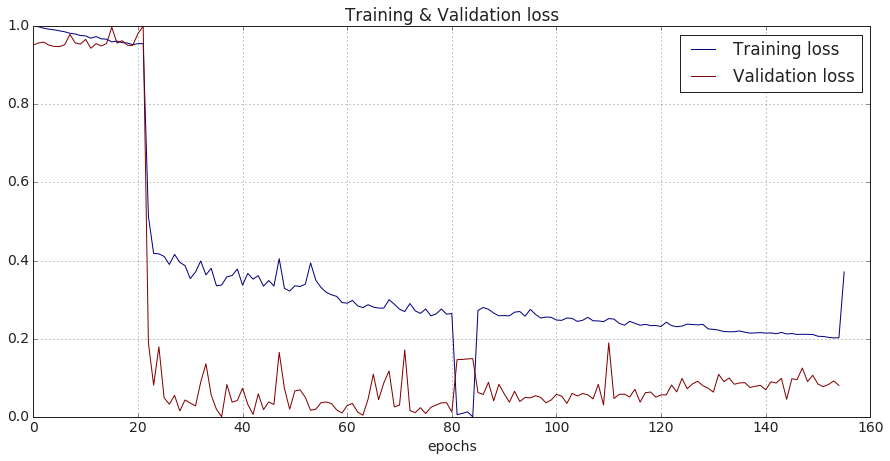

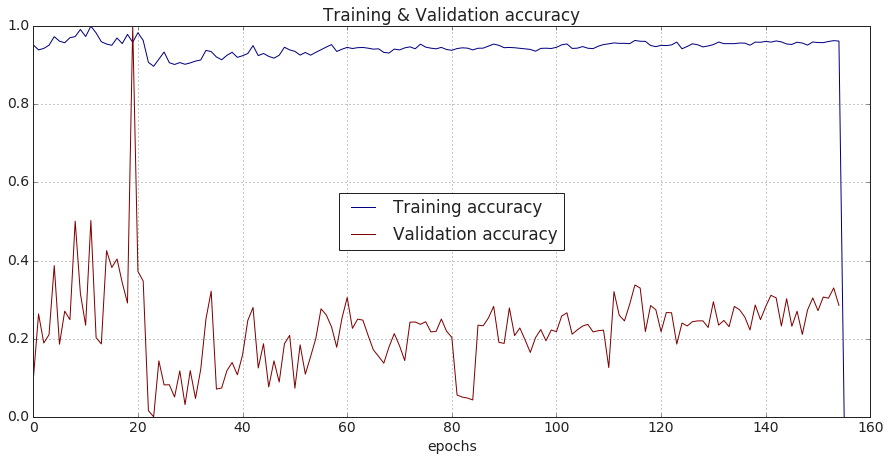

In [111]:

df = pd.read_csv("training.log")

df = df.drop(range(0,20))
df = df.reset_index()

df = df.drop(['epoch'], axis=1)

df -= df.min()
df /= df.max()

# df = df.resample('S')
# df = df.interpolate(method='cubic')

df.columns=["epochs","Training accuracy","Training loss","Validation accuracy","Validation loss"]


params = {
    'grid':True,
    #'lw':2,
    'colormap':'jet',
    #'marker':'.',
    #'markersize':10,
    'figsize':(15,7),
#    'title':'Training accuracy vs loss'
}

ax = df[["Training loss","Validation loss"]].plot(title="Training & Validation loss", **params)
ax.set_xlabel("epochs")
ax = df[["Training accuracy","Validation accuracy"]].plot(title="Training & Validation accuracy", **params)
ax.set_xlabel("epochs")

448


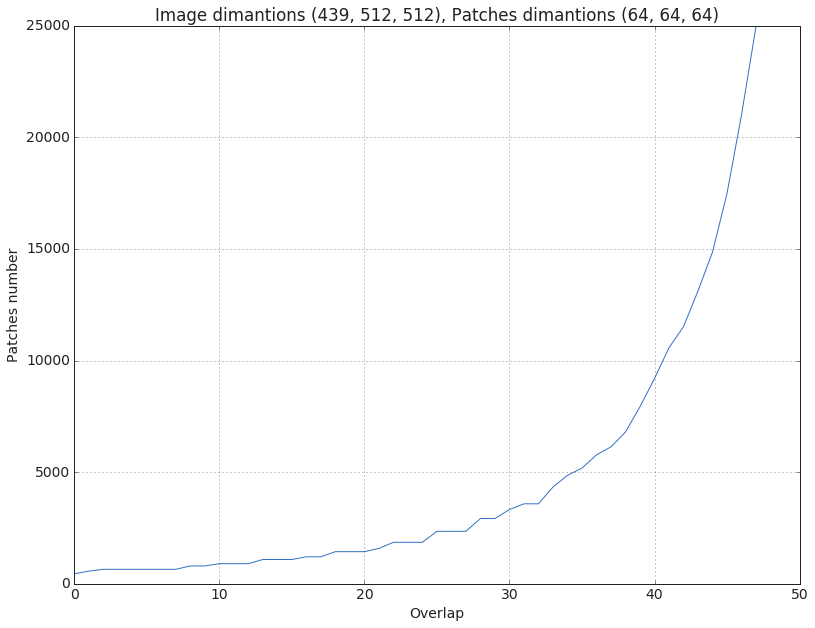

In [36]:
patient = 1 # 1

ct = get_ct_by_index(patient)
mask = get_mask_by_index(patient)

image_shape = np.shape(ct)
patch_shape = 64
overlap = 32

def patches_number(image_shape,patch_shape,overlap):
    return len(compute_patch_indices(image_shape, patch_shape, overlap, start=None))


plt.rc('font', size=14)
f = plt.figure(figsize=(13,10))
p = [patches_number(image_shape,patch_shape,overlap) for overlap in range(48)]

print(p[0])

plt.plot(p)

plt.grid()
plt.title(f"Image dimantions {image_shape}, Patches dimantions {patch_shape,patch_shape,patch_shape}")
plt.ylabel('Patches number')
plt.xlabel('Overlap')
plt.show()


In [160]:
def get_img(index):
    return dcm.read_file(str(test_imgs[index])).pixel_array

def get_mask(index):
    pa = dcm.read_file(str(test_masks[index])).pixel_array.copy()
    pa[pa > 0] = 1
    return pa

def normalize_img(x):
        return (x - x.min()) / (x.max() - x.min())

for i in range(len(test_imgs)):
    case_name = test_imgs[i].stem
    print(f"Case: {test_imgs[i].stem}")
    img = normalize_img(get_img(i))
    mask = get_mask(i)

    image_shape = np.shape(img)
    patch_shape = (64,64,64)
    overlap = 0
    patch_indices = compute_patch_indices(image_shape, patch_shape, overlap, start=None)

    patches = np.array([get_patch_from_3d_data(img, patch_shape, patch_index) for patch_index in patch_indices])
    print(f"patches: {np.shape(patches)}")
    mask_patches = np.array([UnetModel.predict([[[p]]]) for p in patches])
    mask_patches = mask_patches.reshape((64, 64, 64, 64))
    print(f"mask_patches: {np.shape(mask_patches)}")

    predected_mask = reconstruct_from_patches(mask_patches, patch_indices, image_shape, default_value=0)
    np.save( str(TESTDATA_PREDICTIONS/case_name), predected_mask )
    print(f"Saved: {TESTDATA_PREDICTIONS/case_name}.npy")

Case: A038_1
patches: (64, 64, 64, 64)
mask_patches: (64, 64, 64, 64)
None
Saved: /media/amer/BigDisk/testdata_predictions/A038_1
Case: A038_2
patches: (64, 64, 64, 64)
mask_patches: (64, 64, 64, 64)
None
Saved: /media/amer/BigDisk/testdata_predictions/A038_2
Case: A038_3
patches: (64, 64, 64, 64)
mask_patches: (64, 64, 64, 64)
None
Saved: /media/amer/BigDisk/testdata_predictions/A038_3
Case: A059_1
patches: (64, 64, 64, 64)
mask_patches: (64, 64, 64, 64)
None
Saved: /media/amer/BigDisk/testdata_predictions/A059_1
Case: A059_2
patches: (64, 64, 64, 64)
mask_patches: (64, 64, 64, 64)
None
Saved: /media/amer/BigDisk/testdata_predictions/A059_2
Case: A062
patches: (64, 64, 64, 64)
mask_patches: (64, 64, 64, 64)
None
Saved: /media/amer/BigDisk/testdata_predictions/A062
Case: A078_1
patches: (64, 64, 64, 64)
mask_patches: (64, 64, 64, 64)
None
Saved: /media/amer/BigDisk/testdata_predictions/A078_1
Case: A078_2
patches: (64, 64, 64, 64)
mask_patches: (64, 64, 64, 64)
None
Saved: /media/amer/

In [161]:
np.shape(predected_mask),np.shape(mask)

((220, 256, 256), (220, 256, 256))

In [163]:
np.sum(predected_mask - mask)

4051.0

In [166]:
np.sum(predected_mask),np.sum(mask)

(15989.0, 11938)